In [1]:
# Install requirements
!pip install --quiet "lightning" "torchmetrics" "decord" "dahuffman" "pytorch_msssim" "scikit-video"

In [2]:
# Pull source code
!git clone https://github.com/minhngt62/vtl-video-compression.git

Cloning into 'vtl-video-compression'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 248 (delta 27), reused 26 (delta 15), pack-reused 209
Receiving objects: 100% (248/248), 64.63 MiB | 28.11 MiB/s, done.
Resolving deltas: 100% (125/125), done.


In [3]:
# Common import
import os
import math
import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import pandas as pd

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
import torchvision.transforms as T
from lightning.pytorch.loggers import TensorBoardLogger

# Setting the seed
L.seed_everything(42)

# Load videos
import decord as de
ctx = de.cpu(0)
de.bridge.set_bridge("torch")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
# Change working directory
%cd "vtl-video-compression"

/kaggle/working/vtl-video-compression


# Dataset

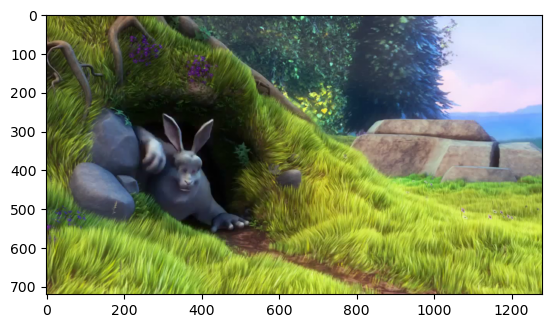

In [5]:
# Build dataset
from video_compression.dataset import BigBuckBunny
bunny_set = BigBuckBunny()
_, frame = next(iter(bunny_set))
plt.imshow(frame.permute(1, 2, 0).numpy())

# Tensorboard

In [6]:
# Dowload ngrok to launch tensorboard
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ./ngrok-stable-linux-amd64.zip

--2023-06-07 07:26:29--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 52.202.168.65, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  15.0MB/s    in 0.9s    

2023-06-07 07:26:30 (15.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ./ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [7]:
# Add auth-token
!./ngrok authtoken 2P8PHZ1vpIpUF8MtajAKNRk5W9l_4KGu3esSWnMqMkSm4E7BL

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [8]:
# Launch and tunnel tensorboard
import os
import multiprocessing
 
pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir ./configs/nerv --host 0.0.0.0 --port 6006 &",
                        "./ngrok http 6006 &"
                        ]]

In [9]:
# curl ngrok port
import time
time.sleep(10) # wait for tensorboard host
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
http://9bb6-34-105-3-78.ngrok-free.app


# Compression

In [10]:
# Load the model
from video_compression.setup import LtNerv
nerv = LtNerv(fc_hw_dim="9_16_112") # NeRV-L
nerv

LtNerv(
  (model): Nerv(
    (pe): PositionalEncoding()
    (stem): Sequential(
      (0): Linear(in_features=80, out_features=512, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=512, out_features=16128, bias=True)
      (3): GELU(approximate='none')
    )
    (layers): ModuleList(
      (0): NervBlock(
        (conv): Upsample(
          (conv): Conv2d(112, 2800, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (up_scale): PixelShuffle(upscale_factor=5)
        )
        (act): GELU(approximate='none')
      )
      (1): NervBlock(
        (conv): Upsample(
          (conv): Conv2d(112, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (up_scale): PixelShuffle(upscale_factor=2)
        )
        (act): GELU(approximate='none')
      )
      (2-4): 3 x NervBlock(
        (conv): Upsample(
          (conv): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (up_scale): PixelShuffle(upscale_factor=2)
    

In [11]:
# Compress the video
from video_compression.setup import train
from video_compression.models.nerv import params_to_prune

nerv_params_to_prune = params_to_prune(nerv.model)
compress_params = dict(
    parameters_to_prune=nerv_params_to_prune,
    prune_ratio=0.4,
    prune_at_epochs=[0.],
)
ckpt_path = train(nerv, bunny_set, compress_params=compress_params)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: Global seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type | Params
-------------------------------
0 | model | Nerv | 12.5 M
-------------------------------
12.5 M    Trainable params
0         Non-trainable params
12.5 M    Total params
50.098    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.


In [12]:
# Benchmark the compression
from video_compression.setup.train_test import test 
test(nerv, bunny_set, weights=ckpt_path)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_loss': 0.016785206273198128,
  'test_psnr': 37.41419982910156,
  'test_msssim': 0.9890729784965515}]